# Example 5:  Modelling of an oxidation experiment

This benchmark describes the simulation of an oxidation experiment with marine pyrite-containing sediments. This modelling study was, together with the experimental work, originally reported by Appelo et al. (1998). The conceptual hydrochemical model and the implemented reaction network proposed for this experiment consists of a complex set of reactive processes. This includes

- the oxidation of pyrite, which is the primary driver of hydrochemical changes
- secondary reactions, such as dissolution of calcite, CO2 sorption, cation and proton exchange and
- oxidation of organic matter, a reaction that competes for the oxidation capacity supplied by the inflow solution. 

The modelling study considers three distinct phases of the experiment. In the first part the sediment material collected in the field was equilibrated with a 280 mmol MgCl<sub>2</sub> solution. In this phase the pore space becomes completely filled with the MgCl<sub>2</sub> solution and the exchangers sites are filled with Mg. In the second phase the column was fed with a more dilute MgCl<sub>2</sub> solution, while in the third phase the column was flushed for 4 pore volumes (at the same flow rate) with a hydrogen peroxide (H<sub>2</sub>O<sub>2</sub>) containing oxidising solution. Particularely the second phase provided the data that allowed to characterise the non-reactive transport  behaviour.

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
import flopy
from mf6rtm import utils
from mf6rtm import mf6rtm
import re
import difflib

prefix = 'ex5'
DT_FMT = "%Y-%m-%d %H:%M:%S"
dataws = os.path.join("data")
databasews = os.path.join("database")


#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 1  # Number of layers
Lx = 0.053 #m
ncol = 16 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1 # Row width ($m$)
top = 2.87433E-03  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 2  # Number of periods
nstp = [64, 100]  # Number of time steps
# nstp = [i*10 for i in nstp]
perlen = [ 0.9333, 1.45833]  # Simulation time ($days$)#100.0
# dt0 = perlen / nstp
tsmult = [1.0, 1.0]  # Time step multiplier
tdis_rc = [(kper, kstep, ts) for kper, kstep, ts in zip(perlen, nstp, tsmult)]

#injection
q = 2.4e-4 #injection rate m3/d
wel_spd = {i: [[(0,0,0), q]] for i in range(0, len(perlen))}


#hydraulic properties
prsity = 0.376 # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*1
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
r_hd = 1
strt = np.ones((nlay, nrow, ncol), dtype=float)

chdspd = [[(i, 0, ncol-1), r_hd] for i in range(nlay)] # Constant head boundary $m$


#transport
dispersivity = 0.00537 #7.5e-5 Longitudinal dispersivity ($m$)
disp_tr_vert = dispersivity*0.01 # Transverse vertical dispersivity ($m$)
disp_tr_hor = dispersivity*0.01 # Transverse horizontal dispersivity ($m$)
diffc = 8.64e-4

icelltype = 1  # Cell conversion type

# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

In [3]:
perlen[0]/64, perlen[1]/100
perlen[0]

0.9333

## Initialize Chemistry in Domain

In [4]:
files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

solutions = utils.solution_df_to_dict(solutionsdf)
solutions
# #assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=float)
# sol_ic = 1
#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#exchange
excdf = pd.read_csv(os.path.join(dataws,f"{prefix}_exchange.csv"), comment = '#',  index_col = 0)
exchangerdic = utils.solution_df_to_dict(excdf)

exchanger = mf6rtm.ExchangePhases(exchangerdic)
exchanger_ic = np.ones((nlay, nrow, ncol), dtype=float)
exchanger_ic[0,0,:4] = 1
exchanger_ic[0,0,4:8] = 2
exchanger_ic[0,0,8:12] = 3
exchanger_ic[0,0,12:] = 4


exchanger.set_ic(exchanger_ic)
eq_solutions = [1,1,1,1]
exchanger.set_equilibrate_solutions(eq_solutions)

#kinetics
kinedic = utils.kinetics_phases_csv_to_dict(os.path.join(dataws,f"{prefix}_kinetic_phases.csv"))
orgsed_form = 'Orgc_sed -1.0 C 1.0' 
kinedic[1]['Orgc_sed'].append(orgsed_form)
kinetics = mf6rtm.KineticPhases(kinedic)
kinetics.set_ic(1)

#eq phases
equilibriums = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws,f"{prefix}_equilibrium_phases.csv"))
equilibriums = mf6rtm.EquilibriumPhases(equilibriums)
equilibriums.set_ic(1)

#surfaces
surfdic = utils.surfaces_csv_to_dict(os.path.join(dataws,f"{prefix}_surfaces.csv"))
surfaces = mf6rtm.Surfaces(surfdic)
surfaces.set_ic(1)
# surfaces.set_options(['no_edl'])

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}', f'mf6rtm'))

# #set database
database = os.path.join(databasews, f'ex5.dat')
model.set_database(database)


model.set_initial_temp([7., 7., 7.])
# #get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)

model.set_exchange_phases(exchanger)
model.set_phases(kinetics)
model.set_phases(equilibriums)
model.set_phases(surfaces)


In [5]:
model.initialize()


Using temperatue of 7.0 from SOLUTION 1 for all cells
Phreeqc initialized


In [6]:
fixed_components = ['Orgc_sed']
# model.set_fixed_components(fixed_components)

In [7]:
wellchem = mf6rtm.ChemStress('wel')
sol_spd = [2,3]
sol_spd
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)
model.wel.data

Initializing ChemStress
ChemStress wel initialized


{0: [111001.4886633894,
  55727.960937482494,
  0.0002887209118285751,
  0.0009999014014963553,
  0.0009999014015639057,
  5.300477329450578,
  9.999014015229526e-06,
  2.6497387141189583,
  0.0,
  9.999014015251628e-06],
 1: [111001.4878796173,
  55500.7456916566,
  0.00018304192688176624,
  9.999014006702425e-05,
  9.999014011008142e-05,
  10.198994296926132,
  0.00019998028022634063,
  5.099497145268265,
  0.0,
  0.00019998028117505526]}

In [8]:
model.sconc

{'H': array([[[111001.99087497, 111001.99087497, 111001.99087497,
          111001.99087497, 111001.99087497, 111001.99087497,
          111001.99087497, 111001.99087497, 111001.99087497,
          111001.99087497, 111001.99087497, 111001.99087497,
          111001.99087497, 111001.99087497, 111001.99087497,
          111001.99087497]]]),
 'O': array([[[55502.54961409, 55502.54961409, 55502.54961409, 55502.54961409,
          55502.54961409, 55502.54961409, 55502.54961409, 55502.54961409,
          55502.54961409, 55502.54961409, 55502.54961409, 55502.54961409,
          55502.54961409, 55502.54961409, 55502.54961409, 55502.54961409]]]),
 'Charge': array([[[-0.00065961, -0.00065961, -0.00065961, -0.00065961,
          -0.00065961, -0.00065961, -0.00065961, -0.00065961,
          -0.00065961, -0.00065961, -0.00065961, -0.00065961,
          -0.00065961, -0.00065961, -0.00065961, -0.00065961]]]),
 'C': array([[[0.58594222, 0.58594222, 0.58594222, 0.58594222, 0.58594222,
          0.58594

In [9]:
for key in wel_spd.keys():
    for i in range(len(wel_spd[key])):
        print(i)
        wel_spd[key][i].extend(model.wel.data[key])
wel_spd

0
0


{0: [[(0, 0, 0),
   0.00024,
   111001.4886633894,
   55727.960937482494,
   0.0002887209118285751,
   0.0009999014014963553,
   0.0009999014015639057,
   5.300477329450578,
   9.999014015229526e-06,
   2.6497387141189583,
   0.0,
   9.999014015251628e-06]],
 1: [[(0, 0, 0),
   0.00024,
   111001.4878796173,
   55500.7456916566,
   0.00018304192688176624,
   9.999014006702425e-05,
   9.999014011008142e-05,
   10.198994296926132,
   0.00019998028022634063,
   5.099497145268265,
   0.0,
   0.00019998028117505526]]}

In [10]:
model.components

['H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Fe', 'Mg', 'Orgc_sed', 'S']

In [11]:
def build_mf6_1d_injection_model(mup3d, nper, tdis_rc, length_units, time_units, nlay, nrow, ncol, delr, delc,
                                 top, botm, wel_spd, chdspd, prsity, k11, k33, dispersivity, icelltype, hclose, 
                                 strt, rclose, relax, nouter, ninner):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    
    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = mup3d.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        # auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            # complexity="complex",
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()
        
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1 # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1   # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'), get_only=['mf6', 'libmf6'])
    
    return sim

In [12]:
sim = build_mf6_1d_injection_model(model, nper, tdis_rc, length_units, time_units, nlay, nrow, ncol, delr, delc,
                                    top, botm, wel_spd, chdspd, prsity, k11, k33, dispersivity, icelltype, hclose, 
                                    strt, rclose, relax, nouter, ninner)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Fe
--- Building IMS package ---
-

--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Mg
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Orgc_sed
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: S
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing solution package ims_1...
  writing solution package ims_2...
  writing solution package ims_3...
  writing solution package ims_4...
  writing solution package ims_5...
  writing solution package ims_6..

    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model C...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Ca...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Cl...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Fe...
    writing model name file...
    writing package dis...
    writing pa

    writing package oc...
  writing model Orgc_sed...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model S...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...


In [13]:
model.run_mup3d(sim, reaction=True)
# run sim with pyemu
# import pyemu
# pyemu.os_utils.run("mf6", cwd=model.wd)




-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, C, Ca, Cl, Fe, Mg, Orgc_sed, S


Starting transport solution at 2024-08-06 12:54:20

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took  0.0001667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 6 iters --- took 0.00021672 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 14 iters --- took 0.00028147 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 16 iters --- took 0.00031665 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 1 --- converged with 21 iters --- took 0.00036655 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 1 --- converged with 25 iters --- took     0.0004 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Tra


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 3 --- converged with 0 iters --- took 0.00014818 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 3 --- converged with 5 iters --- took 0.00021485 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 3 --- converged with 12 iters --- took 0.00026492 mins

Solution 3 finalized



Getting concentration arrays --- time step: 4 --- elapsed time: 0.0437484375

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 5 --- converged with 0 iters --- took 0.00013353 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 5 --- converged with 5 iters --- took 0.00018357 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step:


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 7 --- converged with 0 iters --- took 0.00013317 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 7 --- converged with 5 iters --- took 0.00018322 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 7 --- converged with 12 iters --- took 0.00023323 mins

Solution 3 finalized



Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 9 --- converged with 0 iters --- took 0.00014998 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 9 --- converged with 6 iters --- took  0.0002002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 9 --- converged with 12 iters --- took 0.00027062 mins

Solution 3 finalized



Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 11 --- converged with 0 iters --- took  0.0001665 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 11 --- converged with 4 iters --- took 0.00021667 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 11 --- converged with 10 iters --- took 0.00026835 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 13 --- converged with 0 iters --- took 0.00013345 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 13 --- converged with 5 iters --- took 0.00018332 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 13 --- converged with 11 iters --- took 0.00023323 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 15 --- converged with 0 iters --- took 0.00017527 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 15 --- converged with 5 iters --- took 0.00022543 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 15 --- converged with 11 iters --- took 0.00027705 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 17 --- converged with 0 iters --- took 0.00014842 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 17 --- converged with 5 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 17 --- converged with 11 iters --- took 0.00025008 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 19 --- converged with 0 iters --- took 0.00015003 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 19 --- converged with 4 iters --- took 0.00017988 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 19 --- converged with 10 iters --- took 0.00024675 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 21 --- converged with 0 iters --- took  0.0001501 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 21 --- converged with 4 iters --- took 0.00019995 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 21 --- converged with 10 iters --- took 0.00026673 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 23 --- converged with 0 iters --- took 0.00012673 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 23 --- converged with 4 iters --- took  0.0001768 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 23 --- converged with 10 iters --- took 0.00022877 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 25 --- converged with 0 iters --- took 0.00015165 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 25 --- converged with 4 iters --- took 0.00020168 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 25 --- converged with 10 iters --- took 0.00023527 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 25 --- converged with 11 iters --- took 0.00026842 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 25 --- converged with 15 iters --- took 0.00031363 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 25 --- converged with 19 iters --- took  0.000


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 27 --- converged with 0 iters --- took 0.00015008 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 27 --- converged with 4 iters --- took 0.00020005 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 27 --- converged with 10 iters --- took 0.00026483 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport str


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 29 --- converged with 0 iters --- took 0.00016668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 29 --- converged with 4 iters --- took  0.0002167 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 29 --- converged with 10 iters --- took 0.00026668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport str


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 31 --- converged with 0 iters --- took 0.00016668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 31 --- converged with 4 iters --- took 0.00021668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 31 --- converged with 10 iters --- took 0.00026668 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 33 --- converged with 0 iters --- took 0.00016492 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 33 --- converged with 4 iters --- took 0.00024832 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 33 --- converged with 9 iters --- took  0.0002983 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 35 --- converged with 0 iters --- took 0.00014992 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 35 --- converged with 4 iters --- took  0.0002004 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 35 --- converged with 9 iters --- took  0.0002504 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 35 --- converged with 10 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 37 --- converged with 0 iters --- took 0.00015855 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 37 --- converged with 4 iters --- took  0.0002419 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 37 --- converged with 9 iters --- took 0.00029188 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 39 --- converged with 0 iters --- took 0.00016492 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 39 --- converged with 4 iters --- took 0.00021663 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 39 --- converged with 10 iters --- took 0.00026667 mins

Solution 3 finaliz


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 41 --- converged with 0 iters --- took 0.00018333 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 41 --- converged with 4 iters --- took  0.0002333 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 41 --- converged with 9 iters --- took 0.00028332 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 41 --- converged with 10 iters --- took 0.00032355 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 41 --- converged with 14 iters --- took 0.00039015 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 41 --- converged with 18 iters --- took  0.0004384 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 41 --- 


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 43 --- converged with 4 iters --- took 0.00018333 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 43 --- converged with 10 iters --- took 0.00023335 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 43 --- converged with 11 iters --- took 0.00026667 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 43 --- converged with 15 iters --- took  0.0003167 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 43 --- converged with 19 iters --- took    0.00035 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 43 --- converged with 22 iters --- took     0.0004 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 43 --- 


Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 45 --- converged with 14 iters --- took 0.00038918 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 45 --- converged with 18 iters --- took 0.00044655 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 45 --- converged with 21 iters --- took 0.00049655 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 45 --- converged with 21 iters --- took 0.00052987 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 45 --- converged with 26 iters --- took 0.00059653 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time step: 45 --- converged with 31 iters --- took 0.00065563 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 1 --- time step: 


Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 47 --- converged with 18 iters --- took 0.00039973 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 47 --- converged with 21 iters --- took 0.00044972 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 47 --- converged with 21 iters --- took     0.0005 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 47 --- converged with 26 iters --- took  0.0005516 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time step: 47 --- converged with 31 iters --- took 0.00060155 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 1 --- time step: 47 --- converged with 34 iters --- took  0.0006516 mins

Solution 11 finalized

Getting concentration arrays --- time step: 47 --- elapsed time: 0.67080


Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 49 --- converged with 10 iters --- took 0.00035003 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 49 --- converged with 14 iters --- took 0.00040002 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 49 --- converged with 19 iters --- took  0.0004667 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 49 --- converged with 22 iters --- took 0.00053335 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 49 --- converged with 22 iters --- took 0.00058338 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 49 --- converged with 27 iters --- took  0.0006667 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time ste

Transport stress period: 1 --- time step: 51 --- converged with 9 iters --- took 0.00028337 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 51 --- converged with 10 iters --- took 0.00036667 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 51 --- converged with 14 iters --- took 0.00040183 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 51 --- converged with 19 iters --- took  0.0004667 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 51 --- converged with 22 iters --- took 0.00050182 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 51 --- converged with 22 iters --- took 0.00055195 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 51 --- converged with 27 iters --- too


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 53 --- converged with 0 iters --- took    0.00015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 53 --- converged with 4 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 53 --- converged with 9 iters --- took 0.00026673 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 53 --- converged with 10 iters --- took 0.00030002 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 53 --- converged with 14 iters --- took 0.00036897 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 53 --- converged with 19 iters --- took  0.0004356 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 53 --- 

Transport stress period: 1 --- time step: 55 --- converged with 14 iters --- took 0.00036668 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 55 --- converged with 19 iters --- took 0.00043337 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 55 --- converged with 21 iters --- took  0.0004666 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 55 --- converged with 21 iters --- took 0.00050003 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 55 --- converged with 26 iters --- took 0.00056665 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time step: 55 --- converged with 30 iters --- took 0.00061208 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 1 --- time step: 55 --- converged with 32 iters -


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 57 --- converged with 0 iters --- took 0.00021673 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 57 --- converged with 4 iters --- took 0.00026115 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 57 --- converged with 9 iters --- took   0.000313 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 57 --- converged with 10 iters --- took 0.00034603 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 57 --- converged with 14 iters --- took 0.00040685 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 57 --- converged with 19 iters --- took 0.00045663 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 57 --- 


Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 59 --- converged with 10 iters --- took 0.00029197 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 59 --- converged with 14 iters --- took 0.00034557 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 59 --- converged with 19 iters --- took 0.00039555 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 59 --- converged with 21 iters --- took 0.00043832 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 59 --- converged with 21 iters --- took 0.00047163 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 59 --- converged with 26 iters --- took 0.00052165 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time ste


Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 61 --- converged with 21 iters --- took 0.00048167 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 1 --- time step: 61 --- converged with 21 iters --- took 0.00055877 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 1 --- time step: 61 --- converged with 26 iters --- took 0.00060885 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time step: 61 --- converged with 30 iters --- took 0.00064217 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 1 --- time step: 61 --- converged with 32 iters --- took 0.00069428 mins

Solution 11 finalized

Getting concentration arrays --- time step: 61 --- elapsed time: 0.8749687500000007

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6

Transport stress period: 1 --- time step: 63 --- converged with 25 iters --- took  0.0005498 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 1 --- time step: 63 --- converged with 29 iters --- took 0.00059975 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 1 --- time step: 63 --- converged with 31 iters --- took 0.00064975 mins

Solution 11 finalized

Getting concentration arrays --- time step: 63 --- elapsed time: 0.9041343750000008

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for compone


Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 1 --- converged with 27 iters --- took 0.00052998 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 1 --- converged with 28 iters --- took 0.00057188 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 1 --- converged with 34 iters --- took   0.000634 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time step: 1 --- converged with 37 iters --- took   0.000684 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 1 --- converged with 39 iters --- took 0.00073402 mins

Solution 11 finalized

Getting concentration arrays --- time step: 1 --- elapsed time: 0.9333

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Ch


Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 3 --- converged with 34 iters --- took 0.00052542 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time step: 3 --- converged with 37 iters --- took 0.00055875 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 3 --- converged with 41 iters --- took 0.00060875 mins

Solution 11 finalized

Getting concentration arrays --- time step: 3 --- elapsed time: 0.9624666

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentration

Transport stress period: 2 --- time step: 5 --- converged with 22 iters --- took 0.00041492 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 5 --- converged with 27 iters --- took 0.00048352 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 5 --- converged with 28 iters --- took 0.00051683 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 5 --- converged with 33 iters --- took 0.00058327 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time step: 5 --- converged with 36 iters --- took  0.0006333 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 5 --- converged with 40 iters --- took 0.00068153 mins

Solution 11 finalized

Getting concentration arrays --- time step: 5 --- elapsed time: 0.9916331999999999

Transferring concentrations


Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 7 --- converged with 12 iters --- took 0.00026668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 7 --- converged with 13 iters --- took 0.00031668 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 7 --- converged with 17 iters --- took 0.00038623 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 7 --- converged with 22 iters --- took 0.00046957 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 7 --- converged with 27 iters --- took 0.00051957 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 7 --- converged with 28 iters --- took 0.00056957 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 7 --- conve

Transport stress period: 2 --- time step: 9 --- converged with 5 iters --- took 0.00016668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 9 --- converged with 11 iters --- took 0.00021668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 9 --- converged with 12 iters --- took 0.00025002 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 9 --- converged with 16 iters --- took     0.0003 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 9 --- converged with 21 iters --- took 0.00035002 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 9 --- converged with 26 iters --- took 0.00040002 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 9 --- converged with 27 iters --- took 0.0004


Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 11 --- converged with 0 iters --- took 0.00015007 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 11 --- converged with 5 iters --- took 0.00020053 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 11 --- converged with 11 iters --- took  0.0002667 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 11 --- converged with 13 iters --- took 0.00030002 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 11 --- converged with 17 iters --- took 0.00035003 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 11 --- converged with 22 iters --- took 0.00040008 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 11 ---


Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 13 --- converged with 21 iters --- took  0.0003863 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 13 --- converged with 25 iters --- took 0.00043638 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 13 --- converged with 26 iters --- took 0.00048638 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 13 --- converged with 31 iters --- took 0.00053638 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time step: 13 --- converged with 34 iters --- took 0.00058638 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 13 --- converged with 38 iters --- took 0.00063638 mins

Solution 11 finalized

Getting concentration arrays --- time step: 13 --- elapsed time: 1.10829


Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 15 --- converged with 12 iters --- took  0.0003334 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 15 --- converged with 16 iters --- took 0.00036672 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 15 --- converged with 20 iters --- took 0.00041672 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 15 --- converged with 24 iters --- took 0.00046672 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 15 --- converged with 25 iters --- took 0.00050005 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 15 --- converged with 30 iters --- took 0.00055008 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time ste


Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 17 --- converged with 5 iters --- took  0.0002246 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 17 --- converged with 11 iters --- took 0.00027458 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 17 --- converged with 13 iters --- took 0.00032458 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 17 --- converged with 17 iters --- took  0.0003746 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 2 --- time step: 17 --- converged with 21 iters --- took  0.0004246 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 17 --- converged with 25 iters --- took 0.00047463 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 17 --- 


Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 19 --- converged with 0 iters --- took 0.00015017 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 19 --- converged with 5 iters --- took 0.00020015 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 19 --- converged with 11 iters --- took 0.00026683 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 2 --- time step: 19 --- converged with 13 iters --- took 0.00030017 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 2 --- time step: 19 --- converged with 17 iters --- to


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 21 --- converged with 0 iters --- took 0.00011667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 21 --- converged with 5 iters --- took 0.00016668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 21 --- converged with 11 iters --- took 0.00023543 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 23 --- converged with 0 iters --- took 0.00015002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 23 --- converged with 4 iters --- took 0.00018335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 23 --- converged with 10 iters --- took 0.00023335 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 25 --- converged with 0 iters --- took    0.00015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 25 --- converged with 4 iters --- took     0.0002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 25 --- converged with 10 iters --- took  0.0002831 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport str


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 27 --- converged with 0 iters --- took  0.0001564 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 27 --- converged with 4 iters --- took  0.0002064 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 27 --- converged with 10 iters --- took  0.0002564 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 29 --- converged with 0 iters --- took 0.00015002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 29 --- converged with 5 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 29 --- converged with 10 iters --- took 0.00025002 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 31 --- converged with 0 iters --- took  0.0001837 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 31 --- converged with 4 iters --- took 0.00023372 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 31 --- converged with 9 iters --- took  0.0002837 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 33 --- converged with 0 iters --- took 0.00016667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 33 --- converged with 5 iters --- took 0.00021735 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 33 --- converged with 10 iters --- took 0.00026418 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 35 --- converged with 0 iters --- took 0.00018358 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 35 --- converged with 6 iters --- took 0.00026705 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 35 --- converged with 11 iters --- took 0.00031702 mins

Solution 3 finaliz


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 37 --- converged with 0 iters --- took 0.00017423 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 37 --- converged with 4 iters --- took 0.00024098 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 37 --- converged with 9 iters --- took 0.00031858 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 39 --- converged with 0 iters --- took 0.00016657 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 39 --- converged with 4 iters --- took 0.00021737 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 39 --- converged with 9 iters --- took  0.0002834 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 41 --- converged with 0 iters --- took 0.00016668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 41 --- converged with 4 iters --- took 0.00021668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 41 --- converged with 9 iters --- took 0.00026713 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 43 --- converged with 0 iters --- took 0.00016492 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 43 --- converged with 4 iters --- took 0.00021488 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 43 --- converged with 9 iters --- took 0.00029825 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 45 --- converged with 0 iters --- took 0.00019813 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 45 --- converged with 4 iters --- took 0.00029815 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 45 --- converged with 9 iters --- took 0.00038145 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 47 --- converged with 0 iters --- took 0.00015845 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 47 --- converged with 4 iters --- took  0.0002235 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 47 --- converged with 9 iters --- took  0.0002736 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 49 --- converged with 0 iters --- took 0.00016683 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 49 --- converged with 4 iters --- took 0.00021667 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 49 --- converged with 9 iters --- took 0.00026658 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 51 --- converged with 0 iters --- took    0.00015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 51 --- converged with 4 iters --- took 0.00020038 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 51 --- converged with 9 iters --- took 0.00025002 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 53 --- converged with 0 iters --- took 0.00018342 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 53 --- converged with 4 iters --- took 0.00022087 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 53 --- converged with 9 iters --- took 0.00029507 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 55 --- converged with 0 iters --- took 0.00013335 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 55 --- converged with 4 iters --- took 0.00018335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 55 --- converged with 9 iters --- took 0.00023363 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 57 --- converged with 0 iters --- took 0.00016697 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 57 --- converged with 4 iters --- took 0.00021697 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 57 --- converged with 9 iters --- took 0.00026697 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 59 --- converged with 0 iters --- took 0.00013337 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 59 --- converged with 4 iters --- took 0.00016668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 59 --- converged with 9 iters --- took  0.0002167 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 61 --- converged with 0 iters --- took 0.00016507 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 61 --- converged with 4 iters --- took 0.00021485 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 61 --- converged with 9 iters --- took 0.00026485 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 63 --- converged with 0 iters --- took 0.00016842 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 63 --- converged with 4 iters --- took 0.00021852 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 63 --- converged with 9 iters --- took 0.00029998 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 65 --- converged with 0 iters --- took 0.00016482 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 65 --- converged with 4 iters --- took 0.00019817 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 65 --- converged with 9 iters --- took 0.00024817 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 67 --- converged with 0 iters --- took 0.00014973 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 67 --- converged with 4 iters --- took 0.00019973 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 67 --- converged with 9 iters --- took 0.00026642 mins

Solution 3 finalize


Solving solution 7 - Solving Cl
Transport stress period: 2 --- time step: 68 --- converged with 22 iters --- took 0.00062118 mins

Solution 7 finalized

Solving solution 8 - Solving Fe
Transport stress period: 2 --- time step: 68 --- converged with 24 iters --- took  0.0006548 mins

Solution 8 finalized

Solving solution 9 - Solving Mg
Transport stress period: 2 --- time step: 68 --- converged with 29 iters --- took 0.00070478 mins

Solution 9 finalized

Solving solution 10 - Solving Orgc_sed
Transport stress period: 2 --- time step: 68 --- converged with 29 iters --- took 0.00073812 mins

Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 68 --- converged with 31 iters --- took 0.00078792 mins

Solution 11 finalized

Getting concentration arrays --- time step: 68 --- elapsed time: 1.9103810999999977

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 70 --- converged with 0 iters --- took 0.00011673 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 70 --- converged with 4 iters --- took 0.00016673 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 70 --- converged with 9 iters --- took 0.00021672 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 72 --- converged with 0 iters --- took 0.00015183 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 72 --- converged with 4 iters --- took 0.00020167 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 72 --- converged with 9 iters --- took 0.00025155 mins

Solution 3 finalize


Solution 10 finalized

Solving solution 11 - Solving S
Transport stress period: 2 --- time step: 73 --- converged with 29 iters --- took 0.00059202 mins

Solution 11 finalized

Getting concentration arrays --- time step: 73 --- elapsed time: 1.9832975999999976

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 74 --- converged with 0 iters --- took 0.00015003 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transp


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 75 --- converged with 0 iters --- took 0.00016738 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 75 --- converged with 4 iters --- took  0.0002008 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 75 --- converged with 9 iters --- took  0.0002508 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 77 --- converged with 0 iters --- took 0.00014813 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 77 --- converged with 4 iters --- took 0.00019992 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 77 --- converged with 9 iters --- took 0.00026663 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 79 --- converged with 0 iters --- took 0.00016667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 79 --- converged with 4 iters --- took 0.00021668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 79 --- converged with 9 iters --- took  0.0002667 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 81 --- converged with 0 iters --- took 0.00015015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 81 --- converged with 4 iters --- took 0.00020015 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 81 --- converged with 9 iters --- took 0.00024998 mins

Solution 3 finalize


Getting concentration arrays --- time step: 82 --- elapsed time: 2.1145472999999972

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 83 --- converged with 0 iters --- took 0.00015013 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 83 --- converged with 4 iters --- took 0.00020013 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- t


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 85 --- converged with 0 iters --- took 0.00014982 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 85 --- converged with 4 iters --- took  0.0001998 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 85 --- converged with 9 iters --- took 0.00024982 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 87 --- converged with 0 iters --- took  0.0001667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 87 --- converged with 4 iters --- took 0.00019997 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 87 --- converged with 9 iters --- took 0.00026668 mins

Solution 3 finalize


Getting concentration arrays --- time step: 88 --- elapsed time: 2.202047099999997

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 89 --- converged with 0 iters --- took 0.00016668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 89 --- converged with 4 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- ti


Getting concentration arrays --- time step: 90 --- elapsed time: 2.231213699999997

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 91 --- converged with 0 iters --- took    0.00015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 91 --- converged with 4 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- ti


Getting concentration arrays --- time step: 92 --- elapsed time: 2.260380299999997

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 93 --- converged with 0 iters --- took 0.00013335 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 93 --- converged with 4 iters --- took 0.00018337 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- ti


Getting concentration arrays --- time step: 94 --- elapsed time: 2.289546899999997

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 95 --- converged with 0 iters --- took    0.00015 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 95 --- converged with 4 iters --- took 0.00018333 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- ti


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 97 --- converged with 0 iters --- took 0.00014307 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 97 --- converged with 4 iters --- took 0.00019302 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 97 --- converged with 9 iters --- took 0.00025968 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S

Solving solution 1 - Solving Flow
Transport stress period: 2 --- time step: 99 --- converged with 0 iters --- took 0.00016492 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 2 --- time step: 99 --- converged with 4 iters --- took  0.0002149 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 2 --- time step: 99 --- converged with 9 iters --- took  0.0002483 mins

Solution 3 finalize


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Orgc_sed

Transferring concentrations to mf6 for component: S



Reactive transport solution finished at 2024-08-06 12:54:40 --- it took:    0.33052 mins



MR BEAKER IMPORTANT MESSAGE: SOMETHING WENT WRONG. BUMMER



True

## Figures

In [14]:
wd = os.path.join(f'{prefix}', f'pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr
simapi

# get all ucn files in wd

ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]


In [15]:
#get apelo data
obs = pd.read_csv(os.path.join(dataws, 'ex5_obs.txt'), sep = '\t', skipinitialspace=True)
#replace -9999 with nan
obs.replace(-9999, np.nan, inplace=True)
#drop rows with all nan
obs.dropna(axis=0, how='all', inplace=True)

obs.columns =['vol', 'Mg', 'Ca', 'Alk', 'Cl', 'S(6)', 'pH']
obs.set_index('vol', inplace=True, drop=True)

obs = obs.iloc[3:, :]

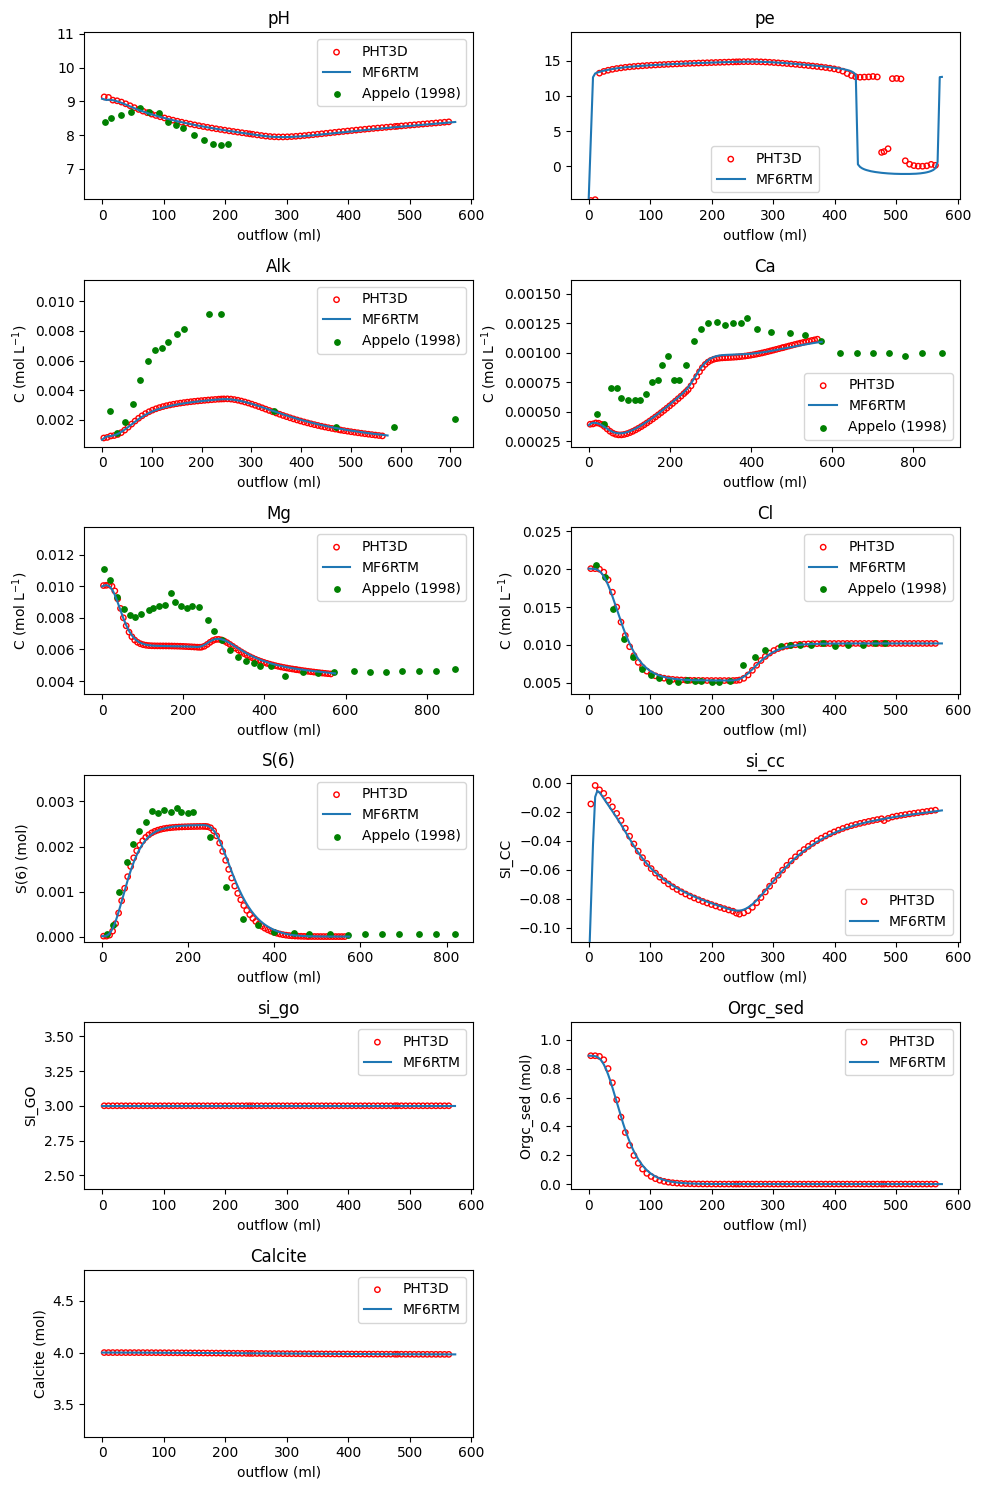

In [16]:
pncol=2
variables = simapi.iloc[:,1:-1].columns #dissolved only
#q from m3/d to ml*3/d

qml = q*1000000

pnrow = calc_rows_from_ncol(variables, pncol)

fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 15))
for var, ax in zip(variables, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == simapi['cell'].max()].copy()
    dfpht3d = simdf[simdf['cell'] == simdf['cell'].max()].copy()
    t = df.index
    # ax.plot([x for x in timespht3d], ucndic[var][:,0,0,0], label = f'{prefix} - PHT3D')
    ax.scatter(dfpht3d.index[::2]*qml, dfpht3d[var][::2], label = f'PHT3D', facecolors='none', edgecolors='r', s=15)
    ax.plot(t*qml, df.loc[:, var], label = f'MF6RTM', 
              zorder = 10)
    if var in obs.columns:
        ax.scatter(obs.index, obs[var], label = 'Appelo (1998)', color='g', s = 15, zorder = 1)
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    ax.set_ylim(xmin*.8, xmax*1.2)

    ax.set_xlabel('outflow (ml)')
    if var not in ['pH', 'pe'] and len(var) < 4:
        ax.set_ylabel('C (mol L$^{-1}$)')
    elif var.startswith('si'):
        ax.set_ylabel(f'{var.upper()}')
    elif len(var) > 3:
        ax.set_ylabel(f'{var} (mol)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
#get rid of last subplot
if len(variables) % pncol:
    fig.delaxes(axs.flatten()[-1])
fig.tight_layout()
fig.savefig(os.path.join(f'{prefix}.png'))